In [1]:
!pip install tsai -q

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *

In [3]:
df = pd.read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)
df.head(1)

,name,date,status,rpm,bearing_abbs,standardized_faults,report_name,zone,area,factory,type,ts_shape_no_nans,ts
0,Main Fan A(F-005A),2022-01-20,hmv,1476.6,{},"[Misalignment,machine, SoftFoot,motor, BaseProblems,motor, BaseProblems,motor, BeltProblem,machine, BaseProblems,machine, CockedBearing,machine, Looseness,machine, Misalignment,machine, XC,machine, BaseProblems,motor, SoftFoot,motor]",RTC220055-9004934-Line 4-F-005A-V001-D-36-3101-22-6144.docx,AZFC Zone 4,New Numan Mill,AZFC,vhr,"(12, 8192)","[[-0.01095184, -0.011836081, -0.012565245, -0.012270509, -0.012300278, -0.013320656, -0.013026895, -0.012533905, -0.013063409, -0.012450588, -0.011686881, -0.012133516, -0.011509651, -0.011013504, -0.01114404, -0.010445369, -0.009850427, -0.01007186, -0.009217497, -0.008727451, -0.008961891, -0.008416777, -0.007894184, -0.008172687, -0.008083154, -0.007089157, -0.006830435, -0.006774916, -0.005936872, -0.005677863, -0.005666965, -0.004578024, -0.004122706, -0.003228867, -0.001870759, -0.001284106, -0.000899825, 0.000474368, 0.000831867, 0.001056994, 0.002552633, 0.003245881, 0.002865068, 0..."


In [4]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])
X.shape, y.shape

((217, 12, 16384), (217,))

In [5]:
# changed split method to split by bearing
X, y = ArrayGenerator.generate_dataset_array(
    dataset_category=4, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'LXC, XC, Looseness', 'Channels taken': 'All', 'Labels array': 'Binary'}


In [6]:
X.shape, y.shape

((868, 3, 16384), (868,))

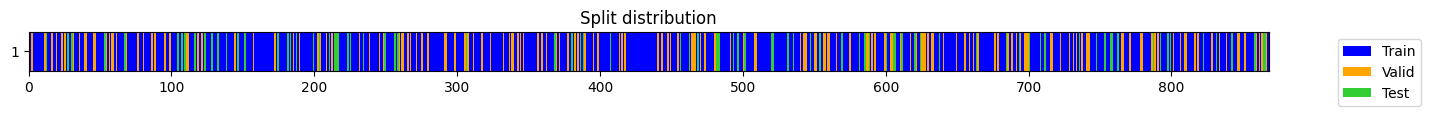

In [7]:
# added test set
report_splits = get_splits(y, valid_size=0.2, test_size=0.1, shuffle=True)

In [8]:
X_train, y_train = X[report_splits[0]], y[report_splits[0]]
X_valid, y_valid = X[report_splits[1]], y[report_splits[1]]
X_test, y_test = X[report_splits[2]], y[report_splits[2]]

In [9]:
#  reduced overlapping percentage to prevent the data from being
X_train, y_train = ArrayGenerator.apply_sliding_window(
    X_train, y_train, window_size=4096, with_fft=True, overlap_pct=0.2
)
X_valid, y_valid = ArrayGenerator.apply_sliding_window(
    X_valid, y_valid, window_size=4096, with_fft=True, overlap_pct=0
)
X_test, y_test = ArrayGenerator.apply_sliding_window(
    X_test, y_test, window_size=4096, with_fft=True, overlap_pct=0
)

In [10]:
X_train.shape, X_valid.shape, X_test.shape

((1510, 3, 2048), (405, 3, 2048), (209, 3, 2048))

valid == train


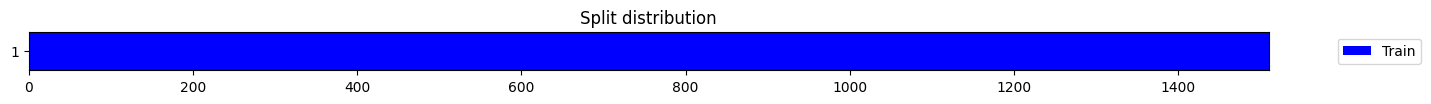

Counter({0: 896, 1: 896})

In [11]:
train_balance_splits = get_splits(
    y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True
)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
Counter(y_train)

In [12]:
X, y, splits = combine_split_data(
    [X_train, X_valid, X_test], [y_train, y_valid, y_test]
)

In [13]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]
dls = get_ts_dls(
    X,
    y,
    splits=splits,
    tfms=tfms,
    shuffle_train=True,
    batch_tfms=batch_tfms,
    bs=[32, 256],
)

In [14]:
#  applying earlystopping to get the best results
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
]

In [15]:
model = MLP(
    dls.vars, dls.c, seq_len=X_train.shape[-1], layers=[16], ps=[0], use_bn=True
)
learn = Learner(
    dls, model, metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()]
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.632831,0.603073,0.748148,0.843137,0.500000,0.627737,0.715665,00:00
1,0.537301,0.497307,0.765432,0.701571,0.779070,0.738292,0.767217,00:00
2,0.424774,0.445495,0.780247,0.717277,0.796512,0.754821,0.782376,00:00
3,0.318287,0.407944,0.804938,0.743455,0.825581,0.782369,0.807640,00:00
4,0.242402,0.360483,0.854321,0.842424,0.808140,0.824926,0.848276,00:00
5,0.189172,0.385264,0.809877,0.738693,0.854651,0.792453,0.815738,00:00
6,0.152730,0.350373,0.854321,0.830409,0.825581,0.827988,0.850559,00:00
7,0.130270,0.367447,0.814815,0.762162,0.819767,0.789916,0.815463,00:00
8,0.111996,0.392105,0.817284,0.766304,0.819767,0.792135,0.817609,00:00
9,0.086819,0.356303,0.859259,0.848485,0.813953,0.830861,0.853329,00:00


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
11,0.070394,0.39414,0.812346,0.75,0.837209,0.791209,0.8156


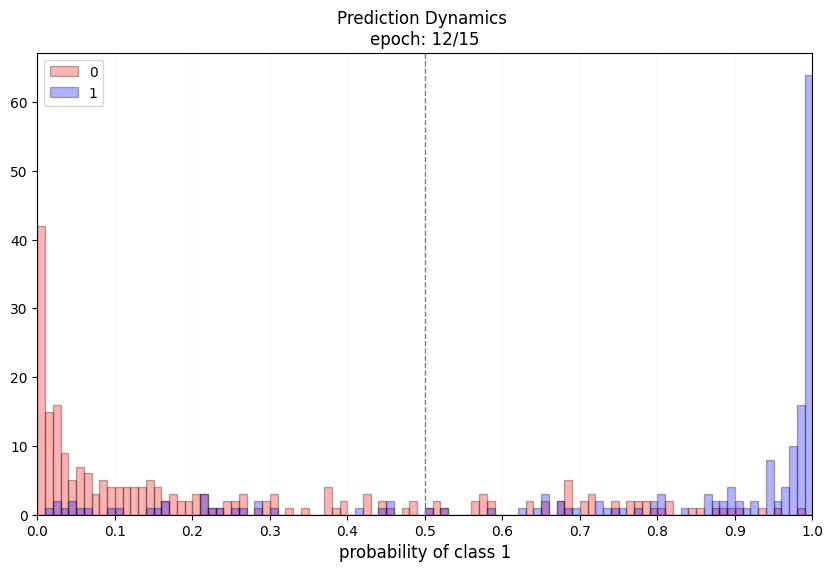

No improvement since epoch 9: early stopping


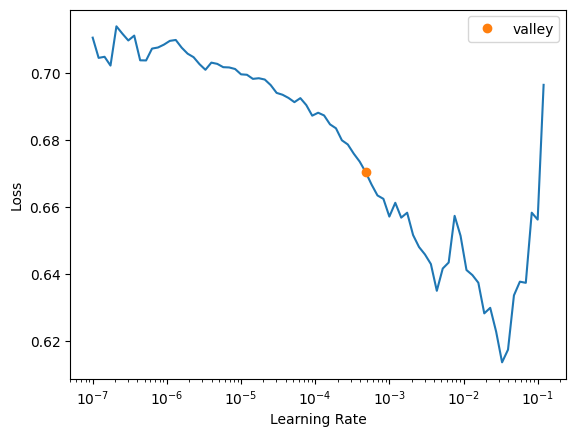

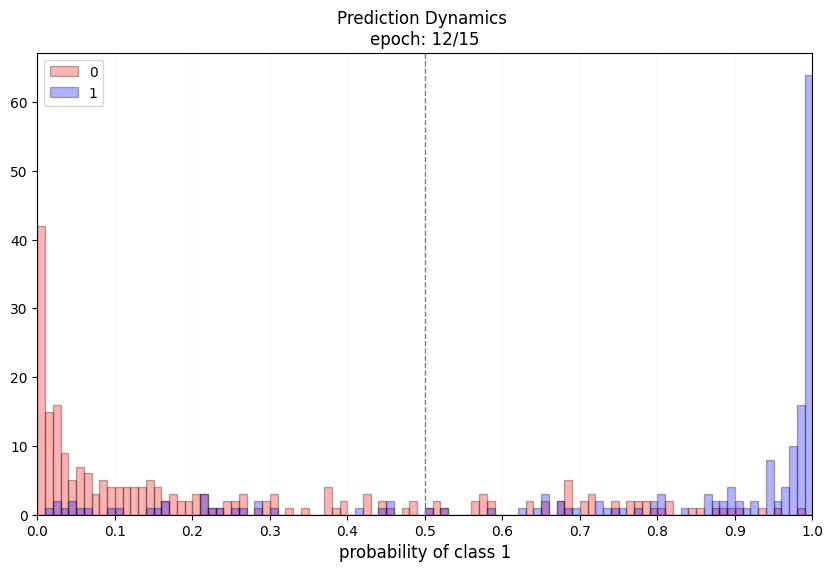

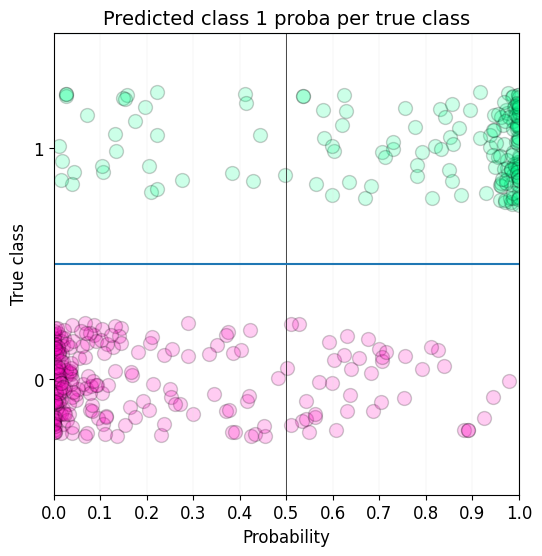

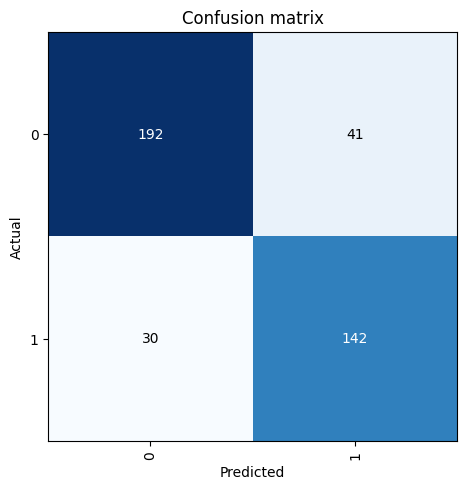

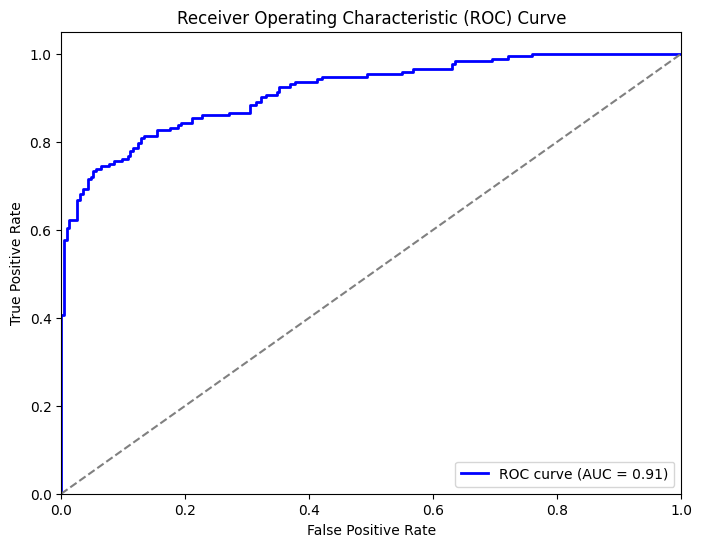

In [16]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=callbacks)
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

* Decent results